In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle
import cv2

print(tf.__version__)

2.17.0


In [10]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_down_samp512.npy")

In [12]:
inputs.shape

(3467, 512, 512, 1)

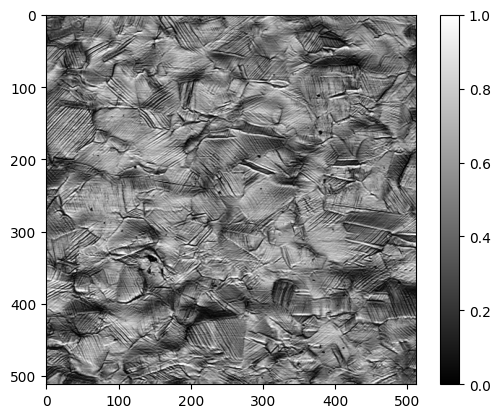

In [13]:
plt.imshow(inputs[0],cmap='grey')
plt.colorbar()

In [14]:
batchsize = 32

with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_down_samp512.npy")
    # train test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(inputs, targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

with tf.device("/CPU:0") :
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
with tf.device("/GPU:0") :
    train_dataset = train_dataset.shuffle(buffer_size=200).batch(batchsize)
    val_dataset = val_dataset.shuffle(buffer_size=200).batch(batchsize)

In [11]:
inputs.shape

(3467, 512, 512, 1)

In [15]:
conv_dim = 16
ff_dim = 32
k_dim = 3
pool_dim = 5
drop_rate = 0.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(512, 512, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 510, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 510, 510, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 102, 102, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 102, 102, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 20, 20, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 3, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,665 (37.75 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 96 (384.00 B)

In [16]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [17]:
model_checkpoint = ModelCheckpoint(
  filepath='CNN3_test3.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

early_stopping = EarlyStopping(
                        monitor="val_accuracy", 
                        patience=20,  
                        mode="max", 
                        restore_best_weights=True  # Automatically restores the best model weights
                        )

optim = model.fit(train_dataset,
                  validation_data=val_dataset, 
                  epochs=400, 
                  callbacks=[model_checkpoint,early_stopping])

Epoch 1/400


I0000 00:00:1734565387.867626  462747 service.cc:146] XLA service 0x78a1ec015e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734565387.867654  462747 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-18 16:43:07.890825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 16:43:08.014402: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-18 16:43:10.002165: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv (f32[16,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,512,512]{3,2,1,0}, f32[32,16,510,510]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0"

10/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5366 - loss: 0.6899

I0000 00:00:1734565391.559271  462747 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5514 - loss: 0.6869 - val_accuracy: 0.4685 - val_loss: 0.7043
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5560 - loss: 0.6825 - val_accuracy: 0.4649 - val_loss: 0.7010
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5547 - loss: 0.6808 - val_accuracy: 0.4486 - val_loss: 0.6987
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5542 - loss: 0.6773 - val_accuracy: 0.4631 - val_loss: 0.7072
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5690 - loss: 0.6724 - val_accuracy: 0.4703 - val_loss: 0.7273
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5760 - loss: 0.6725 - val_accuracy: 0.4703 - val_loss: 0.7509
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5942 - loss: 0.6663 - val_accuracy: 0.4685 - val_loss: 0.7632
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5912 - loss: 0.6666 - val_accuracy: 0.4685 - val_l

In [18]:
"max val accuracy: {0}, min val loss: {1}".format(max(optim.history['val_accuracy']),min(optim.history['val_loss']))

'max val accuracy: 0.8702702522277832, min val loss: 0.2883777916431427'

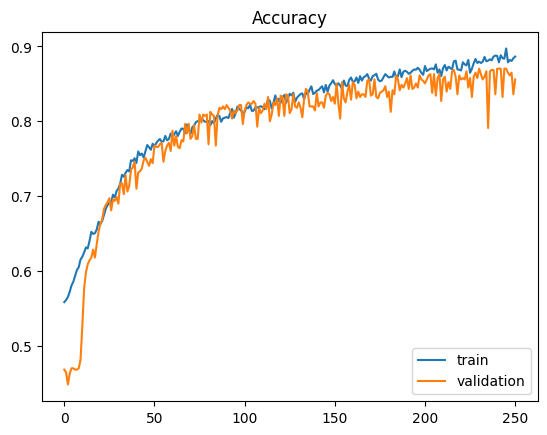

In [19]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

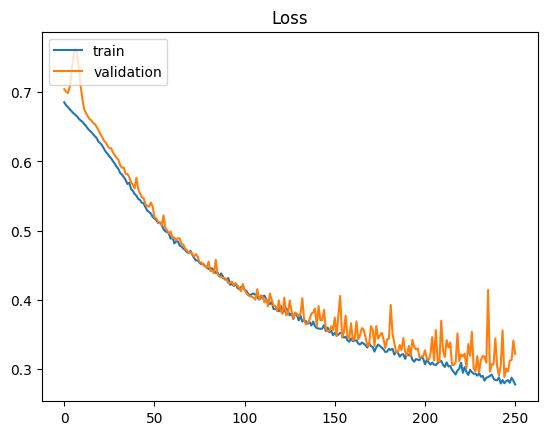

In [20]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [11]:
np.array(optim.history['val_accuracy']).max()

0.8126125931739807

In [21]:
from tensorflow.keras.models import load_model

best_model = load_model('CNN3_test3.keras')

In [22]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8870 - loss: 0.2583


In [23]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.263775110244751, Test accuracy: 0.8890489935874939'

In [24]:
negative_path = 'Sheet 5/test_images/'

# initialize storage of data and labels
images2 = []
labels2 = []

for f in os.listdir(negative_path):
    intensity_image = np.float32( Image.open(negative_path + f))
    down_samp = cv2.resize(intensity_image, (512,512), interpolation=cv2.INTER_LINEAR)
    reshaped_intensity = np.mean(down_samp, axis=-1) 
    image_array = np.expand_dims(reshaped_intensity, axis=-1)
    rescaled_array = image_array/255.0
    images2.append(rescaled_array)
    #print(file)
    #image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    #rescaled_tensor = image_tensor/255.0
    #images2.append(rescaled_tensor)
    labels2.append(0.0)

test_x = np.array(images2)  
test_y = np.array(labels2)  

In [28]:
test_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
test_loss, test_acc = best_model.evaluate(test_x, test_y)
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - loss: 0.7768

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6097 - loss: 0.7523


'Test loss:0.7399636507034302, Test accuracy: 0.6176470518112183'

In [26]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(test_x)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Text(0, 0.5, 'freq')

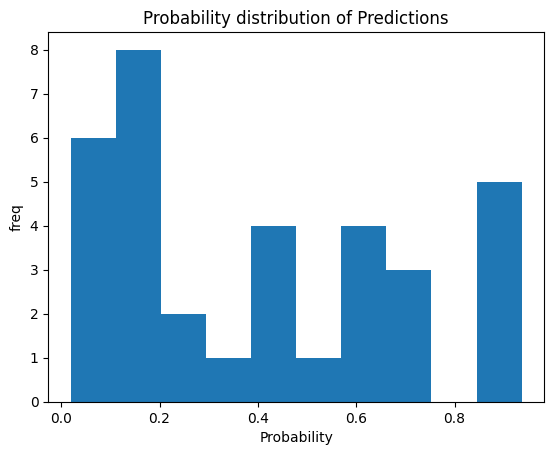

In [27]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

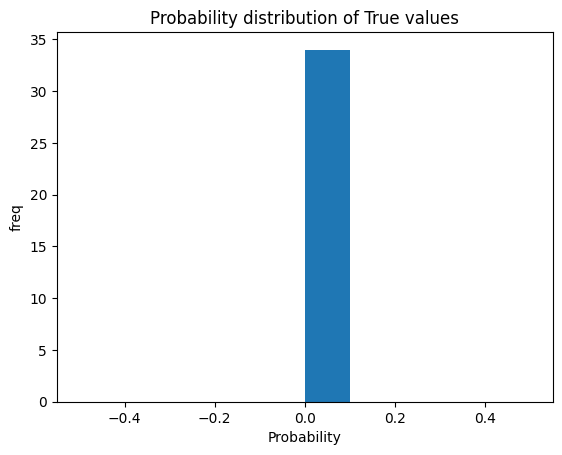

In [23]:
plt.hist(test_y)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [27]:
sum(test_y)

0.0

In [30]:
Y_pred = Y_pred.astype(float).flatten()

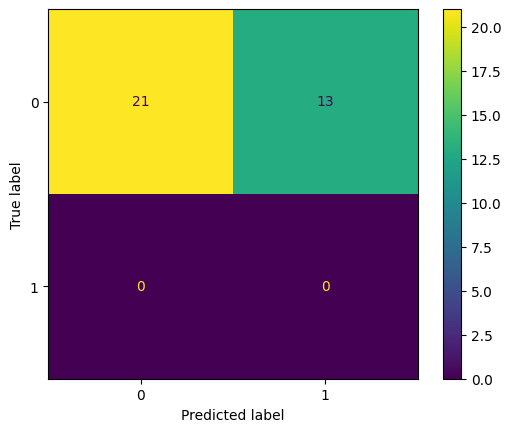

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267

In [32]:
sk.metrics.accuracy_score(test_y, Y_pred)

0.2647058823529412

In [25]:
sk.metrics.precision_score(test_y, Y_pred)

0.0

In [26]:
sk.metrics.recall_score(test_y, Y_pred)

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0